In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import torch
from ogb.nodeproppred import DglNodePropPredDataset

Using backend: pytorch


In [4]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='data/dataset_dgl')
graph = dataset[0][0]

In [5]:
output_emb_file = 'models/deepwalk_01_tr_embedding.npy'

In [6]:
embeddings = np.load(output_emb_file)
embeddings.shape

(87599, 50)

## Train graph

In [7]:
split_idx = dataset.get_idx_split()
graph_train = graph.subgraph(split_idx['train'])
graph_train.add_edges(graph_train.edges()[1], graph_train.edges()[0])
mask_tensor = graph_train.out_degrees() > 0
graph_train = graph_train.subgraph(mask_tensor)

## L2 Distance

In [8]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [9]:
index.train(embeddings)
index.add(embeddings)

In [10]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fdb88055c30> >

In [11]:
index.ntotal

87599

### Check if the closest embedding is a neighbor

In [12]:
distances, indices = index.search(embeddings, 2)

In [13]:
graph_train.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(58180)

In [14]:
graph_train.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [15]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [16]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph_train.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph_train.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [17]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

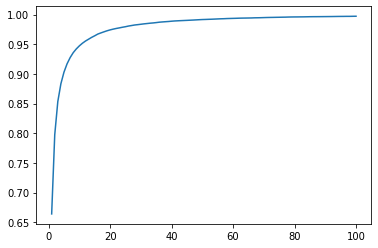

In [18]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [19]:
percentages

tensor([0.6642, 0.7976, 0.8536, 0.8836, 0.9030, 0.9170, 0.9275, 0.9359, 0.9422,
        0.9474, 0.9518, 0.9555, 0.9586, 0.9617, 0.9644, 0.9673, 0.9692, 0.9710,
        0.9728, 0.9743, 0.9756, 0.9767, 0.9777, 0.9788, 0.9797, 0.9808, 0.9817,
        0.9826, 0.9832, 0.9838, 0.9845, 0.9850, 0.9856, 0.9861, 0.9866, 0.9873,
        0.9877, 0.9881, 0.9885, 0.9890, 0.9894, 0.9896, 0.9899, 0.9901, 0.9904,
        0.9907, 0.9909, 0.9912, 0.9915, 0.9918, 0.9919, 0.9921, 0.9923, 0.9925,
        0.9928, 0.9930, 0.9932, 0.9934, 0.9936, 0.9937, 0.9939, 0.9941, 0.9942,
        0.9943, 0.9944, 0.9945, 0.9947, 0.9948, 0.9949, 0.9950, 0.9952, 0.9953,
        0.9954, 0.9955, 0.9956, 0.9957, 0.9958, 0.9960, 0.9961, 0.9962, 0.9962,
        0.9963, 0.9963, 0.9964, 0.9965, 0.9966, 0.9966, 0.9966, 0.9967, 0.9967,
        0.9968, 0.9968, 0.9969, 0.9970, 0.9970, 0.9971, 0.9971, 0.9971, 0.9973,
        0.9973])

In [20]:
percentages.max()

tensor(0.9973)

## Cossine Distance

In [21]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [22]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [23]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [24]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fdb77fb9510> >

In [25]:
index_cos.ntotal

87599

### Check if the closest embedding is a neighbor

In [26]:
distances, indices = index_cos.search(emb_norm, 2)

In [27]:
graph_train.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(58268)

In [28]:
graph_train.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [29]:
max_k = 100
distances, indices = index.search(emb_norm, max_k + 1)

In [30]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph_train.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph_train.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [31]:
has_neighbor

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

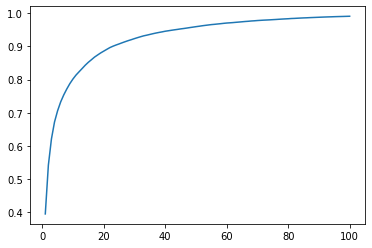

In [32]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [33]:
percentages

tensor([0.3947, 0.5418, 0.6210, 0.6722, 0.7060, 0.7326, 0.7538, 0.7719, 0.7881,
        0.8019, 0.8139, 0.8238, 0.8336, 0.8436, 0.8523, 0.8600, 0.8679, 0.8742,
        0.8805, 0.8859, 0.8913, 0.8966, 0.9008, 0.9044, 0.9077, 0.9112, 0.9146,
        0.9177, 0.9206, 0.9238, 0.9267, 0.9295, 0.9321, 0.9341, 0.9363, 0.9386,
        0.9406, 0.9424, 0.9441, 0.9460, 0.9474, 0.9489, 0.9503, 0.9516, 0.9530,
        0.9542, 0.9556, 0.9570, 0.9584, 0.9598, 0.9611, 0.9625, 0.9637, 0.9649,
        0.9660, 0.9669, 0.9679, 0.9688, 0.9699, 0.9708, 0.9714, 0.9721, 0.9730,
        0.9737, 0.9746, 0.9754, 0.9761, 0.9770, 0.9775, 0.9783, 0.9789, 0.9795,
        0.9799, 0.9804, 0.9810, 0.9815, 0.9822, 0.9827, 0.9833, 0.9837, 0.9844,
        0.9848, 0.9853, 0.9858, 0.9863, 0.9866, 0.9871, 0.9875, 0.9878, 0.9882,
        0.9886, 0.9890, 0.9893, 0.9896, 0.9899, 0.9902, 0.9905, 0.9907, 0.9910,
        0.9913])